# Setup dependencies / Set up GPU acceleration

In [1]:
import tensorflow as tf
import os

In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [3]:
#!pip list # used to make sure correct version of tensorflow is installed for gpu acceleration

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')

In [5]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 1.0 Load and Visualize Data

# 1.1 import flower dataset

In [6]:
from tensorflow import keras

In [7]:
path_train = "Datasets/Flower_dataset/train"

In [8]:
os.listdir(path_train)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [9]:
data = tf.keras.utils.image_dataset_from_directory(path_train,image_size = (128,128),batch_size = 32)

Found 2747 files belonging to 5 classes.


In [10]:
data_iterator = data.as_numpy_iterator()

In [11]:
batch = data_iterator.next()

In [12]:
labels_list = sorted(os.listdir(path_train))
label_dictionary = {labels_list[i]:i for i in range(len(labels_list))}
label_dictionary

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

# 1.2 Visualize data using matplotlib

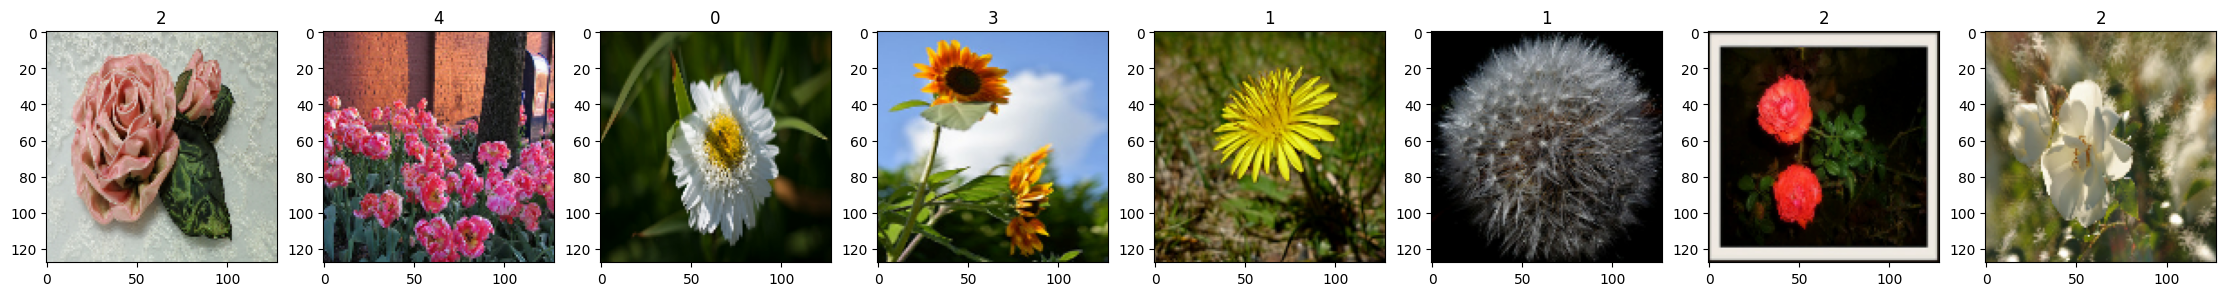

In [13]:
fig,ax = plt.subplots(ncols = 8, figsize = (28,28))
rows = 0
for idx,img in enumerate(batch[0][:8]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 1.3 Apply normalization --> all pixels between 0 - 1

In [14]:
data = data.map(lambda x,y: (x/255,y))

In [15]:
data_iterator = data.as_numpy_iterator()

In [16]:
batch = data_iterator.next()
batch[0].shape

(32, 128, 128, 3)

# 1.4 Create train/test/val data 

### train size ~ 2240 images
### val size ~ 256 images
### test size ~ 256 images

In [17]:
len(data)

86

In [18]:
train_size = int(len(data) * .8) + 2
print(train_size)
val_size = int(len(data) * .10)
print(val_size)
test_size = int(len(data) * .10)
print(test_size)

70
8
8


In [19]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

# 2 Build CNN model

In [20]:
from tensorflow.keras.models import Sequential

In [21]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, MaxPooling2D, BatchNormalization, ReLU, Dropout

In [22]:
from tensorflow.keras.regularizers import l2

In [23]:
def Model():
    model = Sequential()

    # First Layer
    model.add(Conv2D(32,(2,2),1,activation = "relu",padding = "same",input_shape = (128,128,3),kernel_regularizer = l2(0.001)))
    model.add(MaxPooling2D())

    # Second Layer
    model.add(Conv2D(64,(2,2),1,activation = "relu",padding = "same"))
    model.add(MaxPooling2D())

    #Third layer
    model.add(Conv2D(128,(2,2),1,activation = "relu",padding = "same",kernel_regularizer = l2(0.001)))
    model.add(MaxPooling2D())
    
    # Fith Layer
    model.add(Flatten())
    model.add(Dense(128,activation = "relu",kernel_regularizer = l2(0.001)))
    model.add(Dropout(0.5))

    # Final layer
    model.add(Dense(5,activation = "softmax"))
    return model


In [24]:
model = Model()
model.compile('adam',loss = 'sparse_categorical_crossentropy',metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       32896     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 128)      0

# 3 Train the model

In [26]:
results = 'results'

In [27]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=results)

In [28]:
hist = model.fit(train,epochs=20,validation_data=val, callbacks = [tensorboard_callback])

Epoch 1/20
70/70 [==============================] - 8s 27ms/step - loss: 1.6756 - accuracy: 0.3598 - val_loss: 1.2971 - val_accuracy: 0.5430
Epoch 2/20
70/70 [==============================] - 2s 25ms/step - loss: 1.3206 - accuracy: 0.5045 - val_loss: 1.2141 - val_accuracy: 0.5742
Epoch 3/20
70/70 [==============================] - 2s 24ms/step - loss: 1.2173 - accuracy: 0.5536 - val_loss: 1.1435 - val_accuracy: 0.6406
Epoch 4/20
70/70 [==============================] - 2s 23ms/step - loss: 1.1731 - accuracy: 0.5813 - val_loss: 1.0275 - val_accuracy: 0.6875
Epoch 5/20
70/70 [==============================] - 2s 23ms/step - loss: 1.1049 - accuracy: 0.6210 - val_loss: 1.0096 - val_accuracy: 0.6641
Epoch 6/20
70/70 [==============================] - 2s 23ms/step - loss: 1.0512 - accuracy: 0.6478 - val_loss: 0.9902 - val_accuracy: 0.7031
Epoch 7/20
70/70 [==============================] - 2s 23ms/step - loss: 1.0169 - accuracy: 0.6719 - val_loss: 0.9631 - val_accuracy: 0.7148
Epoch 8/20
70

# 3.1 Model evaulation

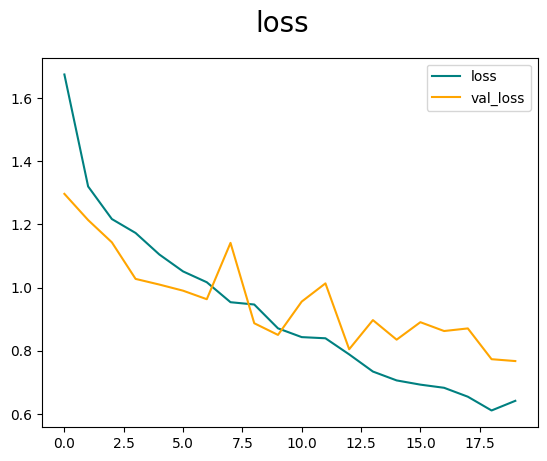

In [29]:
fig = plt.figure()
plt.plot(hist.history['loss'], color = 'teal', label = "loss")
plt.plot(hist.history['val_loss'], color = 'orange', label = "val_loss")
fig.suptitle('loss', fontsize = 20)
plt.legend()
plt.show()

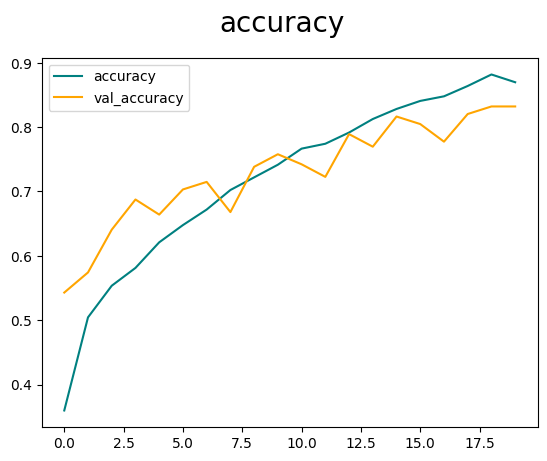

In [30]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color = 'teal', label = "accuracy")
plt.plot(hist.history['val_accuracy'], color = 'orange', label = "val_accuracy")
fig.suptitle('accuracy', fontsize = 20)
plt.legend()
plt.show()

# 4 Test on test set

In [31]:
l = a = c = 0
for batch in test.as_numpy_iterator():
    X,y = batch
    loss,accuracy = model.evaluate(X,y)
    l += loss
    a += accuracy
    c += 1
    

1/1 [==============================] - 0s 134ms/step - loss: 1.0988 - accuracy: 0.7778


In [32]:
print("average loss = ",l / c)

average loss =  0.9664156064391136


In [33]:
print("average accuracy = ",a / c)

average accuracy =  0.7730034738779068


# 5. Interpret results and save

In [34]:
model.save("CNN_model_of_184-1.h5")

# 6. Build MLP model 

In [35]:
def model_MLP():
    model = Sequential()
    
    model.add(Flatten(input_shape = (128,128,3)))
    model.add(Dense(128,activation = "ReLU",kernel_regularizer = l2(0.001)))
    model.add(Dropout(0.2))

    model.add(Dense(256,activation = "ReLU",kernel_regularizer = l2(0.001)))
    model.add(Dropout(0.2))

    model.add(Dense(5,activation = "softmax"))

    return model
    

    

In [36]:
MLP = model_MLP() 
MLP.compile('adam',loss = 'sparse_categorical_crossentropy',metrics=['accuracy'])

In [37]:
MLP.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 49152)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               6291584   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               33024     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 6,325,893
Trainable params: 6,325,893
No

In [38]:
results_MLP = 'results_MLP'

In [39]:
tensorboard_callback_MLP = tf.keras.callbacks.TensorBoard(log_dir=results_MLP)

In [40]:
hist_MLP = model.fit(train,epochs=20,validation_data=val, callbacks = [tensorboard_callback_MLP])

Epoch 1/20
70/70 [==============================] - 2s 24ms/step - loss: 0.5828 - accuracy: 0.8973 - val_loss: 0.9612 - val_accuracy: 0.8164
Epoch 2/20
70/70 [==============================] - 2s 23ms/step - loss: 0.5735 - accuracy: 0.9036 - val_loss: 0.7940 - val_accuracy: 0.8281
Epoch 3/20
70/70 [==============================] - 2s 23ms/step - loss: 0.5527 - accuracy: 0.9112 - val_loss: 0.9377 - val_accuracy: 0.8164
Epoch 4/20
70/70 [==============================] - 2s 23ms/step - loss: 0.5615 - accuracy: 0.8982 - val_loss: 0.9026 - val_accuracy: 0.8203
Epoch 5/20
70/70 [==============================] - 2s 23ms/step - loss: 0.6000 - accuracy: 0.8893 - val_loss: 0.8628 - val_accuracy: 0.8477
Epoch 6/20
70/70 [==============================] - 2s 23ms/step - loss: 0.5674 - accuracy: 0.9004 - val_loss: 0.9111 - val_accuracy: 0.8398
Epoch 7/20
70/70 [==============================] - 2s 22ms/step - loss: 0.5440 - accuracy: 0.9174 - val_loss: 0.8479 - val_accuracy: 0.8398
Epoch 8/20
70

In [41]:
l = a = c = 0
for batch in test.as_numpy_iterator():
    X,y = batch
    loss,accuracy = model.evaluate(X,y)
    l += loss
    a += accuracy
    c += 1

1/1 [==============================] - 0s 27ms/step - loss: 1.8391 - accuracy: 0.7407


In [42]:
print("average loss = ",l / c)

average loss =  1.226292446255684


In [43]:
print("average accuracy = ",a / c)

average accuracy =  0.7957175895571709


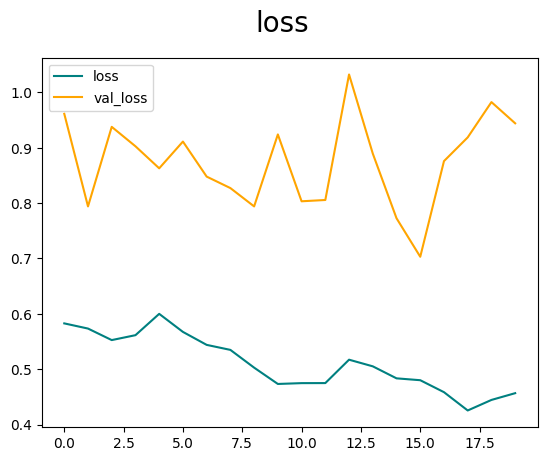

In [44]:
fig = plt.figure()
plt.plot(hist_MLP.history['loss'], color = 'teal', label = "loss")
plt.plot(hist_MLP.history['val_loss'], color = 'orange', label = "val_loss")
fig.suptitle('loss', fontsize = 20)
plt.legend()
plt.show()

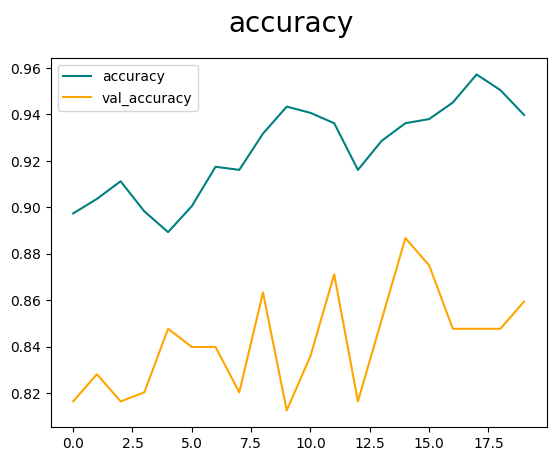

In [45]:
fig = plt.figure()
plt.plot(hist_MLP.history['accuracy'], color = 'teal', label = "accuracy")
plt.plot(hist_MLP.history['val_accuracy'], color = 'orange', label = "val_accuracy")
fig.suptitle('accuracy', fontsize = 20)
plt.legend()
plt.show()

In [46]:
MLP.save("MLP_model_of_184.h5")

# 7. Results:
## CNN: 79.9% accuracy    ----  MLP: 83% accuracy

# 8.0 New Dataset - Dandelion vs Daisy

## 8.1 Load in new dataset

In [47]:
path_data_train = "Datasets/Daisy_Dandelion/train"
path_data_val = "Datasets/Daisy_Dandelion/valid"
path_data_test = "Datasets/Daisy_Dandelion/test"

In [48]:
os.listdir(path_data_train)

['daisy', 'dandelion']

In [49]:
data_train = tf.keras.utils.image_dataset_from_directory(path_data_train,image_size = (128,128),batch_size = 32)
data_val = tf.keras.utils.image_dataset_from_directory(path_data_val,image_size = (128,128),batch_size = 32)
data_test = tf.keras.utils.image_dataset_from_directory(path_data_test,image_size = (128,128),batch_size = 32)

Found 1275 files belonging to 2 classes.
Found 364 files belonging to 2 classes.
Found 182 files belonging to 2 classes.


In [50]:
data_iterator_train = data_train.as_numpy_iterator()
data_iterator_val = data_val.as_numpy_iterator()
data_iterator_test = data_test.as_numpy_iterator()

In [51]:
batch = data_iterator_train.next()

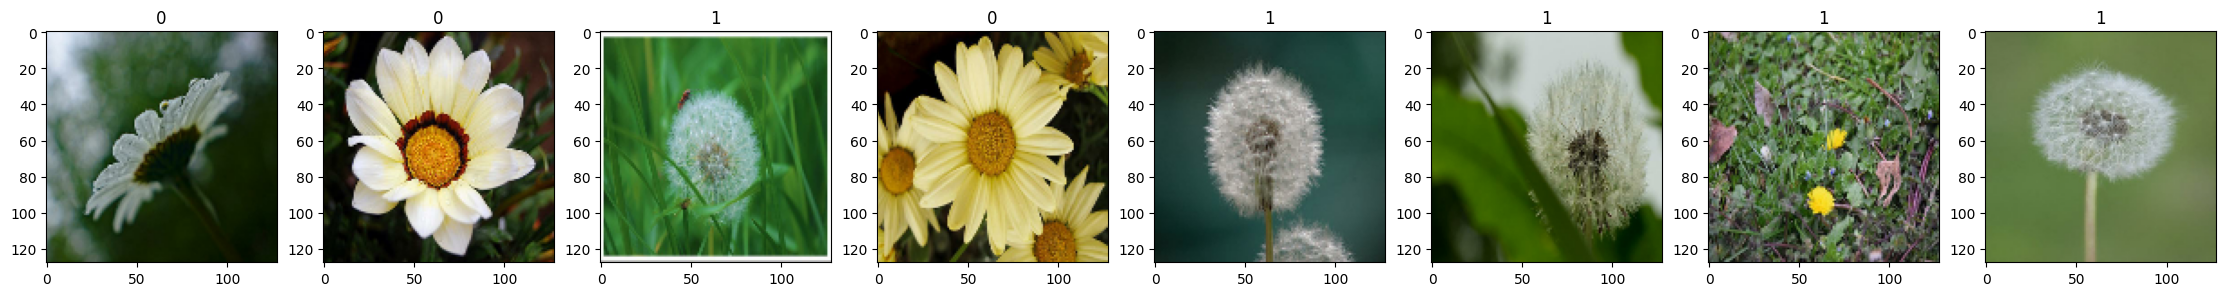

In [52]:
fig,ax = plt.subplots(ncols = 8, figsize = (28,28))
rows = 0
for idx,img in enumerate(batch[0][:8]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [53]:
labels_list = sorted(os.listdir(path_data_train))
label_dictionary = {labels_list[i]:i for i in range(len(labels_list))}
label_dictionary

{'daisy': 0, 'dandelion': 1}

In [54]:
data_train = data_train.map(lambda x,y: (x/255,y))
data_val = data_val.map(lambda x,y: (x/255,y))
data_test = data_test.map(lambda x,y: (x/255,y))

In [55]:
data_iterator_train = data_train.as_numpy_iterator()
data_iterator_val = data_val.as_numpy_iterator()
data_iterator_test = data_test.as_numpy_iterator()

In [56]:
batch_train = data_iterator_train.next()
batch_train[0].shape

(32, 128, 128, 3)

# 8.2 Create train/test/val data 

### train size ~ 1275  images
### val size ~ 364 images
### test size ~ 182 images

In [57]:
train_size = int(len(data_train))
print(train_size)
val_size = int(len(data_val))
print(val_size)
test_size = int(len(data_test))
print(test_size)

40
12
6


In [58]:
X = data_train.take(train_size)
V = data_val.take(val_size)
T = data_test.take(test_size)

# 8.3 Build Model

In [83]:
def Model_2():
    model = Sequential()

    # First Layer
    model.add(Conv2D(64,(2,2),1,activation = "relu",padding = "same",input_shape = (128,128,3),kernel_regularizer = l2(0.001)))
    model.add(MaxPooling2D())

    # Second Layer
    model.add(Conv2D(128,(2,2),1,activation = "relu",padding = "same"))
    model.add(MaxPooling2D())

    #Third layer
    model.add(Conv2D(256,(2,2),1,activation = "relu",padding = "same",kernel_regularizer = l2(0.001)))
    model.add(MaxPooling2D())
    
    # Fith Layer
    model.add(Flatten())
    model.add(Dense(64,activation = "relu",kernel_regularizer = l2(0.001)))
    model.add(Dropout(0.5))

    # Final layer
    model.add(Dense(1,activation = "sigmoid"))
    return model


In [84]:
model_2 = Model_2()
model_2.compile('adam',loss = 'binary_crossentropy',metrics=['accuracy'])

In [85]:
model_2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 128, 64)      832       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 128)       32896     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 256)       131328    
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 16, 16, 256)     

In [86]:
results_m2 = 'results_m2'

In [87]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=results_m2)

In [89]:
hist_m2 = model_2.fit(X,epochs=40,validation_data=V, callbacks = [tensorboard_callback])

Epoch 1/40
40/40 [==============================] - 3s 39ms/step - loss: 0.9073 - accuracy: 0.5741 - val_loss: 0.7938 - val_accuracy: 0.5632
Epoch 2/40
40/40 [==============================] - 1s 25ms/step - loss: 0.7222 - accuracy: 0.6596 - val_loss: 0.6641 - val_accuracy: 0.7143
Epoch 3/40
40/40 [==============================] - 1s 25ms/step - loss: 0.6587 - accuracy: 0.7286 - val_loss: 0.7436 - val_accuracy: 0.6071
Epoch 4/40
40/40 [==============================] - 1s 25ms/step - loss: 0.6091 - accuracy: 0.7490 - val_loss: 0.5641 - val_accuracy: 0.7747
Epoch 5/40
40/40 [==============================] - 1s 25ms/step - loss: 0.5298 - accuracy: 0.7992 - val_loss: 0.4843 - val_accuracy: 0.8187
Epoch 6/40
40/40 [==============================] - 1s 25ms/step - loss: 0.4792 - accuracy: 0.8267 - val_loss: 0.4631 - val_accuracy: 0.8379
Epoch 7/40
40/40 [==============================] - 1s 25ms/step - loss: 0.4677 - accuracy: 0.8227 - val_loss: 0.4713 - val_accuracy: 0.8159
Epoch 8/40
40

# 8.4 Visualize and Interpret Results

In [90]:
l = a = c = 0
for batch in T.as_numpy_iterator():
    train_x,y = batch
    loss,accuracy = model_2.evaluate(train_x,y)
    l += loss
    a += accuracy
    c += 1

1/1 [==============================] - 0s 299ms/step - loss: 0.9161 - accuracy: 0.9091


In [91]:
print("average loss = ",l / c)

average loss =  0.6420009036858877


In [92]:
print("average accuracy = ",a / c)

average accuracy =  0.8546401560306549


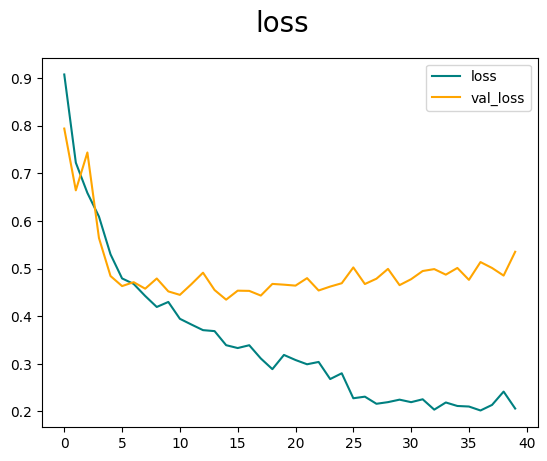

In [93]:
fig = plt.figure()
plt.plot(hist_m2.history['loss'], color = 'teal', label = "loss")
plt.plot(hist_m2.history['val_loss'], color = 'orange', label = "val_loss")
fig.suptitle('loss', fontsize = 20)
plt.legend()
plt.show()

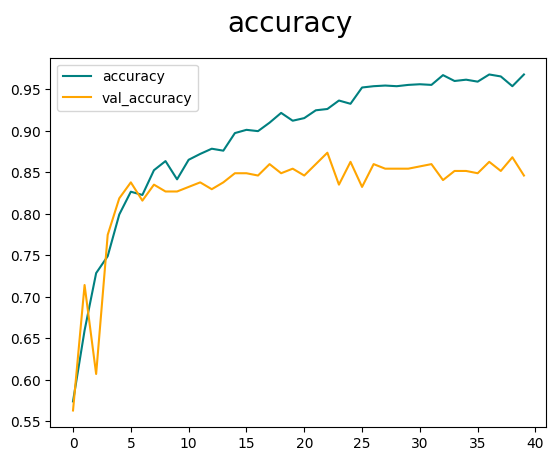

In [94]:
fig = plt.figure()
plt.plot(hist_m2.history['accuracy'], color = 'teal', label = "accuracy")
plt.plot(hist_m2.history['val_accuracy'], color = 'orange', label = "val_accuracy")
fig.suptitle('accuracy', fontsize = 20)
plt.legend()
plt.show()

In [95]:
model_2.save("CNN_model_of_184-1(dandelion/daisy.h5")

# 9.0 Build MLP

In [72]:
def model_MLP_2():
    model = Sequential()
    
    model.add(Flatten(input_shape = (128,128,3)))
    model.add(Dense(128,activation = "ReLU",kernel_regularizer = l2(0.001)))
    model.add(Dropout(0.2))

    model.add(Dense(64,activation = "ReLU",kernel_regularizer = l2(0.001)))
    model.add(Dropout(0.2))

    model.add(Dense(1,activation = "sigmoid"))

    return model
    

In [73]:
MLP_2 = model_MLP_2() 
MLP_2.compile('adam',loss = 'binary_crossentropy',metrics=['accuracy'])

In [74]:
MLP_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 49152)             0         
                                                                 
 dense_7 (Dense)             (None, 128)               6291584   
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6,299,905
Trainable params: 6,299,905
No

In [75]:
results_MLP_2 = 'results_MLP_2'

In [76]:
tensorboard_callback_MLP = tf.keras.callbacks.TensorBoard(log_dir=results_MLP_2)

In [77]:
hist_MLP_2 = MLP_2.fit(X,epochs=40,validation_data=V, callbacks = [tensorboard_callback_MLP])

Epoch 1/40
40/40 [==============================] - 1s 16ms/step - loss: 4.9462 - accuracy: 0.5059 - val_loss: 1.0787 - val_accuracy: 0.6346
Epoch 2/40
40/40 [==============================] - 1s 14ms/step - loss: 1.3891 - accuracy: 0.5224 - val_loss: 1.0332 - val_accuracy: 0.5027
Epoch 3/40
40/40 [==============================] - 1s 15ms/step - loss: 0.9743 - accuracy: 0.6125 - val_loss: 0.9340 - val_accuracy: 0.5577
Epoch 4/40
40/40 [==============================] - 1s 14ms/step - loss: 0.9554 - accuracy: 0.5867 - val_loss: 0.9470 - val_accuracy: 0.5604
Epoch 5/40
40/40 [==============================] - 1s 14ms/step - loss: 0.9275 - accuracy: 0.5914 - val_loss: 0.9135 - val_accuracy: 0.5632
Epoch 6/40
40/40 [==============================] - 1s 13ms/step - loss: 0.8913 - accuracy: 0.5976 - val_loss: 0.8849 - val_accuracy: 0.5577
Epoch 7/40
40/40 [==============================] - 1s 14ms/step - loss: 0.8633 - accuracy: 0.5976 - val_loss: 0.8540 - val_accuracy: 0.5879
Epoch 8/40
40

# 9.1 Visualize and Interpret Results

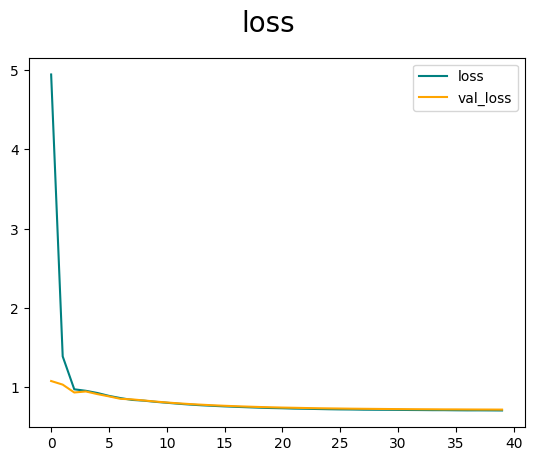

In [78]:
fig = plt.figure()
plt.plot(hist_MLP_2.history['loss'], color = 'teal', label = "loss")
plt.plot(hist_MLP_2.history['val_loss'], color = 'orange', label = "val_loss")
fig.suptitle('loss', fontsize = 20)
plt.legend()
plt.show()

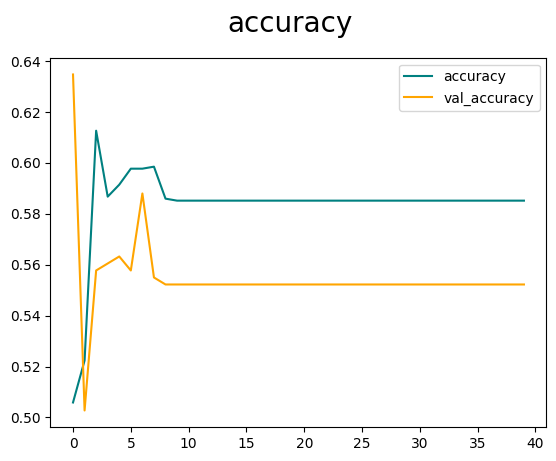

In [79]:
fig = plt.figure()
plt.plot(hist_MLP_2.history['accuracy'], color = 'teal', label = "accuracy")
plt.plot(hist_MLP_2.history['val_accuracy'], color = 'orange', label = "val_accuracy")
fig.suptitle('accuracy', fontsize = 20)
plt.legend()
plt.show()

#

In [80]:
l = a = c = 0
for batch in T.as_numpy_iterator():
    train_x,y = batch
    loss,accuracy = MLP_2.evaluate(train_x,y)
    l += loss
    a += accuracy
    c += 1

1/1 [==============================] - 0s 25ms/step - loss: 0.6583 - accuracy: 0.7273


In [81]:
print("average loss = ",l / c)

average loss =  0.7069384157657623


In [82]:
print("average accuracy = ",a / c)

average accuracy =  0.5847537914911906


In [96]:
MLP_2.save("MLP_model_of_184-1(dandelion/daisy.h5")

# 10. Results:
## CNN: 85% accuracy    ----  MLP: 58.4% accuracy